## Let’s get started

I’ll start by importing modules and loading the data set into Python environment:

In [5]:
import pandas as pd
import numpy as np
data = pd.read_csv("../data/train.csv", index_col="Loan_ID")

# #1 – Boolean Indexing

What do you do, if you want to filter values of a column based on conditions from another set of columns? For instance, we want a list of all females who are not graduate and got a loan. Boolean indexing can help here. You can use the following code:

In [6]:
data.loc[(data["Gender"]=="Female") & (data["Education"]=="Not Graduate") & (data["Loan_Status"]=="Y"), ["Gender","Education","Loan_Status"]]

,Gender,Education,Loan_Status
Loan_ID,,,
LP001155,Female,Not Graduate,Y
LP001669,Female,Not Graduate,Y
LP001692,Female,Not Graduate,Y
LP001908,Female,Not Graduate,Y
LP002300,Female,Not Graduate,Y
LP002314,Female,Not Graduate,Y
LP002407,Female,Not Graduate,Y
LP002489,Female,Not Graduate,Y
LP002502,Female,Not Graduate,Y


# #2 – Apply Function

It is one of the commonly used functions for playing with data and creating new variables. Apply returns some value after passing each row/column of a data frame with some function. The function can be both default or user-defined. For instance, here it can be used to find the #missing values in each row and column.

In [7]:
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Missing values per column:")
print data.apply(num_missing, axis=0) #axis=0 defines that function is to be applied on each column

Missing values per column:
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [8]:
#Applying per row:
print "\nMissing values per row:"
print data.apply(num_missing, axis=1).head() #axis=1 defines that function is to be applied on each row


Missing values per row:
Loan_ID
LP001002    1
LP001003    0
LP001005    0
LP001006    0
LP001008    0
dtype: int64


Thus we get the desired result.

Note: head() function is used in second output because it contains many rows.

# #3 – Imputing missing files

‘fillna()’ does it in one go. It is used for updating missing values with the overall mean/mode/median of the column. Let’s impute the ‘Gender’, ‘Married’ and ‘Self_Employed’ columns with their respective modes.

In [9]:
#First we import a function to determine the mode
from scipy.stats import mode
mode(data['Gender'])

/opt/conda/envs/python2/lib/python2.7/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


ModeResult(mode=array(['Male'], dtype=object), count=array([489]))

Output: ModeResult(mode=array([‘Male’], dtype=object), count=array([489]))

This returns both mode and count. Remember that mode can be an array as there can be multiple values with high frequency. We will take the first one by default always using:

In [10]:
mode(data['Gender']).mode[0]

'Male'

Now we can fill the missing values and check using num_missing.



In [11]:
#Impute the values:
data['Gender'].fillna(mode(data['Gender']).mode[0], inplace=True)
data['Married'].fillna(mode(data['Married']).mode[0], inplace=True)
data['Self_Employed'].fillna(mode(data['Self_Employed']).mode[0], inplace=True)

#Now check the #missing values again to confirm:
print data.apply(num_missing, axis=0)

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Hence, it is confirmed that missing values are imputed. Please note that this is the most primitive form of imputation. Other sophisticated techniques include modeling the missing values, using grouped averages (mean/mode/median).

# #4 – Pivot Table

Pandas can be used to create MS Excel style pivot tables. For instance, in this case, a key column is “LoanAmount” which has missing values. We can impute it using mean amount of each ‘Gender’, ‘Married’ and ‘Self_Employed’ group. The mean ‘LoanAmount’ of each group can be determined as:

In [14]:
data.pivot_table?

In [13]:
#Determine pivot table
impute_grps = data.pivot_table(values=["LoanAmount"], index=["Gender","Married","Self_Employed"], aggfunc=np.mean)
print impute_grps

                              LoanAmount
Gender Married Self_Employed            
Female No      No             114.691176
               Yes            125.800000
       Yes     No             134.222222
               Yes            282.250000
Male   No      No             129.936937
               Yes            180.588235
       Yes     No             153.882736
               Yes            169.395833


# #5 – Multi-Indexing

If you notice the output of step #3, it has a strange property. Each index is made up of a combination of 3 values. This is called Multi-Indexing. It helps in performing operations really fast.

Continuing the example from #3, we have the values for each group but they have not been imputed.
This can be done using the various techniques learned till now.

In [25]:
#iterate only through rows with missing LoanAmount
for i,row in data.loc[data['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  data.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]

#Now check the #missing values again to confirm:
print data.apply(num_missing, axis=0)

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Note:

Multi-index requires tuple for defining groups of indices in loc statement. This a tuple used in function.
The .values[0] suffix is required because, by default a series element is returned which has an index not matching with that of the dataframe. In this case, a direct assignment gives an error.

# #6. Crosstab

This function is used to get an initial “feel” (view) of the data. Here, we can validate some basic hypothesis. For instance, in this case, “Credit_History” is expected to affect the loan status significantly. This can be tested using cross-tabulation as shown below:



In [26]:
pd.crosstab(data["Credit_History"],data["Loan_Status"],margins=True)

Loan_Status,N,Y,All
Credit_History,,,
0.0,82,7,89
1.0,97,378,475
All,179,385,564


These are absolute numbers. But, percentages can be more intuitive in making some quick insights. We can do this using the apply function:

In [27]:
def percConvert(ser):
  return ser/float(ser[-1])
pd.crosstab(data["Credit_History"],data["Loan_Status"],margins=True).apply(percConvert, axis=1)

Loan_Status,N,Y,All
Credit_History,,,
0.0,0.921348,0.078652,1.0
1.0,0.204211,0.795789,1.0
All,0.317376,0.682624,1.0


Now, it is evident that people with a credit history have much higher chances of getting a loan as 80% people with credit history got a loan as compared to only 9% without credit history.

But that’s not it. It tells an interesting story. Since I know that having a credit history is super important, what if I predict loan status to be Y for ones with credit history and N otherwise. Surprisingly, we’ll be right 82+378=460 times out of 614 which is a whopping 75%!

I won’t blame you if you’re wondering why the hell do we need statistical models. But trust me, increasing the accuracy by even 0.001% beyond this mark is a challenging task. Would you take this challenge?

Note: 75% is on train set. The test set will be slightly different but close. Also, I hope this gives some intuition into why even a 0.05% increase in accuracy can result in jump of 500 ranks on the Kaggle leaderboard.



# #7 – Merge DataFrames

Merging dataframes become essential when we have information coming from different sources to be collated. Consider a hypothetical case where the average property rates (INR per sq meters) is available for different property types. Let’s define a dataframe as:

In [28]:
prop_rates = pd.DataFrame([1000, 5000, 12000], index=['Rural','Semiurban','Urban'],columns=['rates'])
prop_rates

,rates
Rural,1000
Semiurban,5000
Urban,12000


Now we can merge this information with the original dataframe as:

In [29]:
data_merged = data.merge(right=prop_rates, how='inner',left_on='Property_Area',right_index=True, sort=False)
data_merged.pivot_table(values='Credit_History',index=['Property_Area','rates'], aggfunc=len)

Property_Area  rates
Rural          1000     179.0
Semiurban      5000     233.0
Urban          12000    202.0
Name: Credit_History, dtype: float64

The pivot table validates successful merge operation. Note that the ‘values’ argument is irrelevant here because we are simply counting the values.

# #8 – Sorting DataFrames
Pandas allow easy sorting based on multiple columns. This can be done as:

In [30]:
data_sorted = data.sort_values(['ApplicantIncome','CoapplicantIncome'], ascending=False)
data_sorted[['ApplicantIncome','CoapplicantIncome']].head(10)

,ApplicantIncome,CoapplicantIncome
Loan_ID,,
LP002317,81000,0.0
LP002101,63337,0.0
LP001585,51763,0.0
LP001536,39999,0.0
LP001640,39147,4750.0
LP002422,37719,0.0
LP001637,33846,0.0
LP001448,23803,0.0
LP002624,20833,6667.0


Note: Pandas “sort” function is now deprecated. We should use “sort_values” instead.

# #9 – Plotting (Boxplot & Histogram)

Many of you might be unaware that boxplots and histograms can be directly plotted in Pandas and calling matplotlib separately is not necessary. It’s just a 1-line command. For instance, if we want to compare the distribution of ApplicantIncome by Loan_Status:

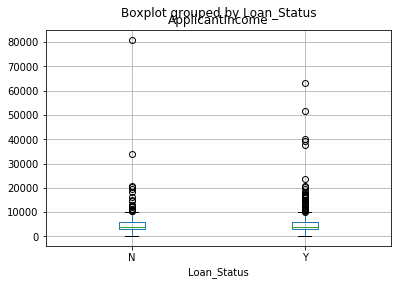

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
data.boxplot(column="ApplicantIncome",by="Loan_Status")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fef234510>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8feef81f50>], dtype=object)

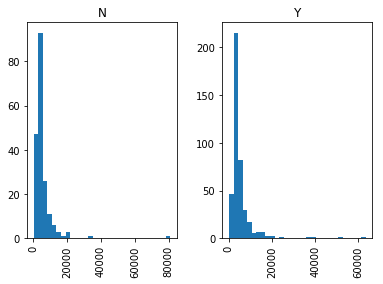

In [32]:
data.hist(column="ApplicantIncome",by="Loan_Status",bins=30)


This shows that income is not a big deciding factor on its own as there is no appreciable difference between the people who received and were denied the loan.